In [ ]:
import os
print("Current working directory:", os.getcwd())

In [2]:
import os
import shutil

# Define the directory containing the images
source_dir = '/Users/dk/Desktop/dk_unet-270524/path_nets/'  # Change this to your source directory

# Get the list of all files in the source directory
files = os.listdir(source_dir)

# Process each file in the source directory
for file_name in files:
    # Check if the file is an image (optional: adjust the extensions as needed)
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Extract the base name (without extension)
        base_name = os.path.splitext(file_name)[0]
        
        # Define the new directory structure
        new_dir = os.path.join(source_dir, base_name)
        
        # Create the new directory structure
        os.makedirs(new_dir, exist_ok=True)
        
        # Create the 'images' and 'masks' folders inside the new directory
        images_dir = os.path.join(new_dir, 'images')
        masks_dir = os.path.join(new_dir, 'masks')
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(masks_dir, exist_ok=True)
        
        # Define the new file path in the 'images' folder
        new_file_path = os.path.join(images_dir, file_name)
        
        # Define the current file path
        current_file_path = os.path.join(source_dir, file_name)
        
        # Move the file to the new file path
        shutil.move(current_file_path, new_file_path)

print("All images have been moved to their respective 'images' folders and 'masks' folders have been created.")



All images have been moved to their respective 'images' folders and 'masks' folders have been created.


In [ ]:
#move images to train and test datasets

In [3]:
import cv2
import numpy as np
import os

def segment_and_enhance_nets(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define the color range for the fluorescent marker
    lower_color = np.array([30, 30, 30])  # Adjusted lower threshold to include lighter regions
    upper_color = np.array([90, 255, 255])
    # Create a mask for the color
    mask = cv2.inRange(hsv, lower_color, upper_color)
    # Apply the mask to get the segmented NETs
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    # Convert the segmented image to grayscale
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    # Enhance shapes using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    enhanced = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    enhanced = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, kernel)
    return enhanced, mask

def process_images_with_masks(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            images_dir = os.path.join(root, dir_name, 'images')
            masks_dir = os.path.join(root, dir_name, 'masks')
            if os.path.exists(images_dir):
                if not os.path.exists(masks_dir):
                    os.makedirs(masks_dir)
                
                for filename in os.listdir(images_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        # Load the image
                        image_path = os.path.join(images_dir, filename)
                        image = cv2.imread(image_path)
                        
                        if image is not None:
                            # Segment and enhance the image
                            enhanced_image, mask = segment_and_enhance_nets(image)
                            
                            # Prepare the output filename
                            base_name = os.path.splitext(filename)[0]
                            output_filename = f"{base_name}_mask.jpg"
                            output_path = os.path.join(masks_dir, output_filename)
                            
                            # Save the mask image
                            cv2.imwrite(output_path, mask)
                            print(f"Mask created and saved: {output_path}")
                        else:
                            print(f"Failed to load image: {image_path}")

# Example usage
root_directory = "/Users/dk/Desktop/dk_unet-270524/path_nets/"
process_images_with_masks(root_directory)

Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/test/DFO_2h_DFO-Zeitkinetik_2/masks/DFO_2h_DFO-Zeitkinetik_2_mask.jpg
Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/test/Ctr_1h_DFO-Zeitkinetik_2/masks/Ctr_1h_DFO-Zeitkinetik_2_mask.jpg
Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/test/Ctr_2h_DFO-Zeitkinetik_4/masks/Ctr_2h_DFO-Zeitkinetik_4_mask.jpg
Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/train/DFO_2h_DFO-Zeitkinetik_6/masks/DFO_2h_DFO-Zeitkinetik_6_mask.jpg
Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/train/DFO+PMA_4h_DFO-Zeitkinetik_6/masks/DFO+PMA_4h_DFO-Zeitkinetik_6_mask.jpg
Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/train/PMA_3h_DFO-Zeitkinetik_5/masks/PMA_3h_DFO-Zeitkinetik_5_mask.jpg
Mask created and saved: /Users/dk/Desktop/dk_unet-270524/path_nets/train/DFO_3h_DFO-Zeitkinetik_5/masks/DFO_3h_DFO-Zeitkinetik_5_mask.jpg
Mask created and saved: /User

In [4]:
import cv2
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, Cropping2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

import tensorflow as tf

# Set some parameters
# Set some parameters
IMG_WIDTH = 128 # change 
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Define path
TRAIN_PATH = '/Users/dk/Desktop/dk_unet-270524/path_nets/train/'
TEST_PATH = '/Users/dk/Desktop/dk_unet-270524/path_nets/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
import os
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 6/6 [00:00<00:00, 34.05it/s]

Getting and resizing test images ... 



100%|██████████| 3/3 [00:00<00:00, 61.15it/s]

Done!


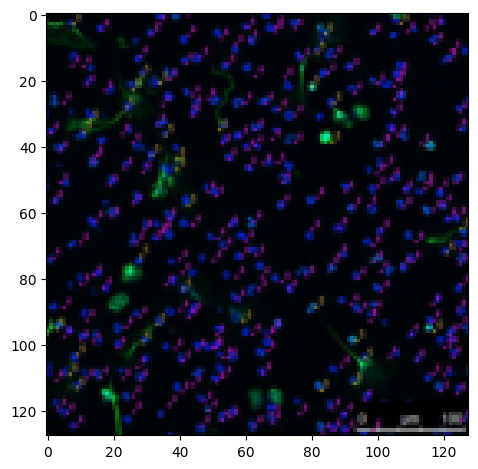

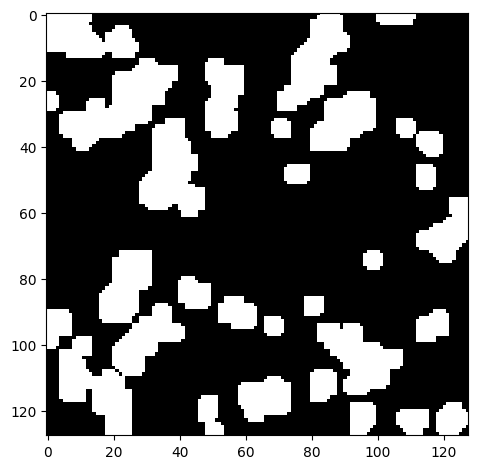

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [8]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-05-30 10:21:26.038052: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-30 10:21:26.038110: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-30 10:21:26.038125: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-30 10:21:26.038421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 10:21:26.038829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [10]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/50


2024-05-30 10:21:30.451726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.6944 - accuracy: 0.4960
Epoch 1: val_loss improved from inf to 0.69130, saving model to model-dsbowl2018-1.h5
1/1 [==============================] - 3s 3s/step - loss: 0.6944 - accuracy: 0.4960 - val_loss: 0.6913 - val_accuracy: 0.5334
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5347

/Users/dk/Desktop/dk_unet-270524/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.69130 to 0.68854, saving model to model-dsbowl2018-1.h5
1/1 [==============================] - 0s 209ms/step - loss: 0.6903 - accuracy: 0.5347 - val_loss: 0.6885 - val_accuracy: 0.5539
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5582
Epoch 3: val_loss improved from 0.68854 to 0.68562, saving model to model-dsbowl2018-1.h5
1/1 [==============================] - 0s 186ms/step - loss: 0.6861 - accuracy: 0.5582 - val_loss: 0.6856 - val_accuracy: 0.5655
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.5826
Epoch 4: val_loss improved from 0.68562 to 0.68064, saving model to model-dsbowl2018-1.h5
1/1 [==============================] - 0s 171ms/step - loss: 0.6806 - accuracy: 0.5826 - val_loss: 0.6806 - val_accuracy: 0.5902
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.6107
Epoch 5: val_loss improved from 0.68064 to 0.67629, saving model t

In [11]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

1/1 [==============================] - 0s 156ms/step


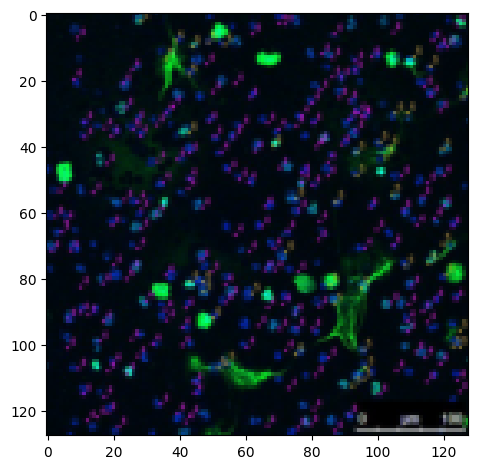

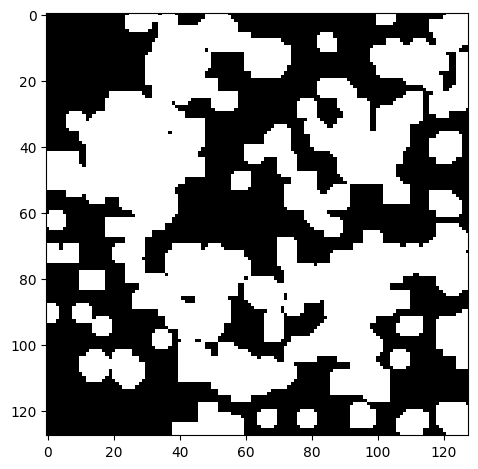

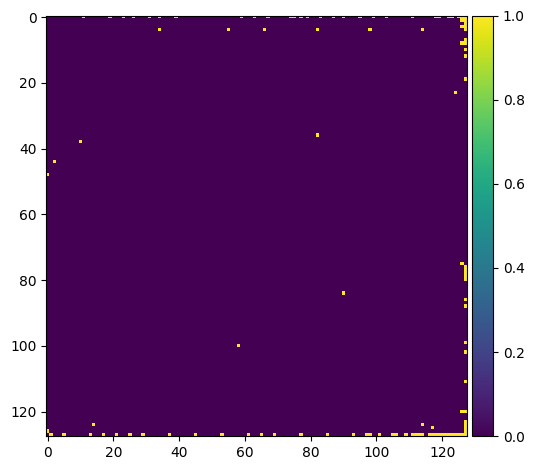

In [34]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

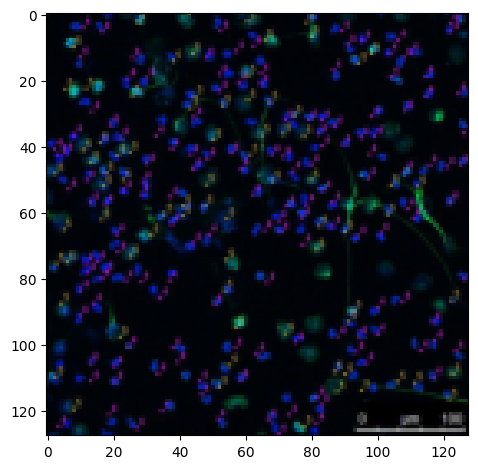

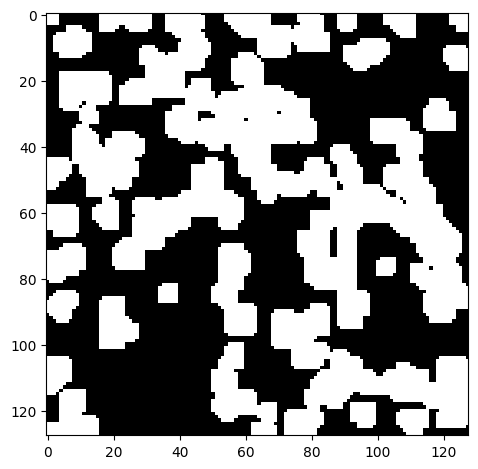

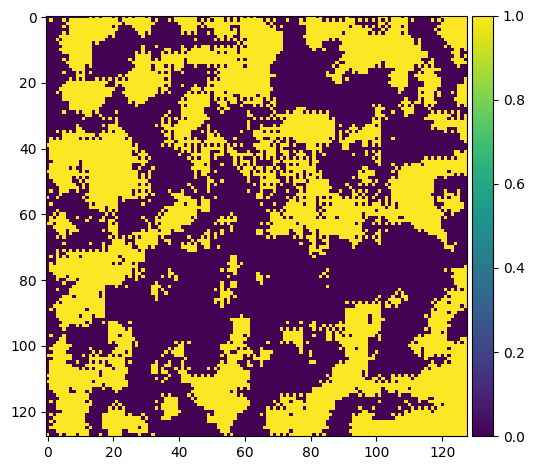

In [12]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [13]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [14]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [15]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)